## 2018 Ebola outbreak in the DRC

Reproducing [Christian Althaus' results](https://github.com/calthaus/Ebola/tree/master/DRC%20%28GitHub%202018%29) with a stochastic model.

This notebook simply generates the data that will feed the accompanying interactive dashboard. For details on the estimation procedure itself, please refer to the [repository of `sdeparams`](https://github.com/cparrarojas/sde-parameter-estimation) and the examples therein.

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams.sdeparams as sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

### Model setup

Matrices defining the linear-noise approximation.

In [2]:
ndim = 3
N = 1.0e6
sigma = 1./9.31
gamma = 1./7.41
tau = 28.

def A(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([-beta*np.exp(-k*delta)*s*i/N, beta*np.exp(-k*delta)*s*i/N - sigma*e, sigma*e - gamma*i])

def B(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([[beta*np.exp(-k*delta)*s*i/N, -beta*np.exp(-k*delta)*s*i/N, 0.],
                     [-beta*s*np.exp(-k*delta)*i/N, beta*np.exp(-k*delta)*s*i/N + sigma*e, -sigma*e],
                     [0., -sigma*e, sigma*e + gamma*i]])

def J(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([[-beta*np.exp(-k*delta)*i/N, 0., -beta*np.exp(-k*delta)*s/N],
                     [beta*np.exp(-k*delta)*i/N, -sigma, beta*np.exp(-k*delta)*s/N],
                     [0., sigma, -gamma]])

The function below returns one realisation of the (full) SDEs

In [3]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    x_t = []
    
    x_0 = x.copy()
    for time in t:
        x_t.append(x_0.copy())
        y = A(x_0, time, *params)*dt + np.sqrt(dt)*np.random.multivariate_normal(np.zeros(ndim), B(x_0, time, *params))
        x_0 += np.maximum(y, -np.array(x_0))
            
    return np.array(x_t)

### Parameter estimation

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/calthaus/Ebola/master/DRC%20(GitHub%202018)/Ebola_outbreak_DRC2018_data.csv')
data.Date = pd.to_datetime(data.Date)

In [5]:
data.head()

,Date,Cumulative,Cases
0,2018-04-05,1,1
1,2018-04-06,1,0
2,2018-04-07,1,0
3,2018-04-08,2,1
4,2018-04-09,2,0


In [6]:
observations = (N - data.Cumulative.values, data.index.values)

zimmer = sdeparams.Zimmer(A, B, J, observations, ndim, n_obs=1, estimate_N=False, N=1)

In [7]:
bounds = [(0., 0.), (1., 1.), (0.1, 5.), (0.01, 2.)]

estimation = differential_evolution(zimmer.costfn, bounds)

Best fit parameters

In [8]:
params_estim = tuple(estimation.x)

Text(0,0.5,'$R_t$')

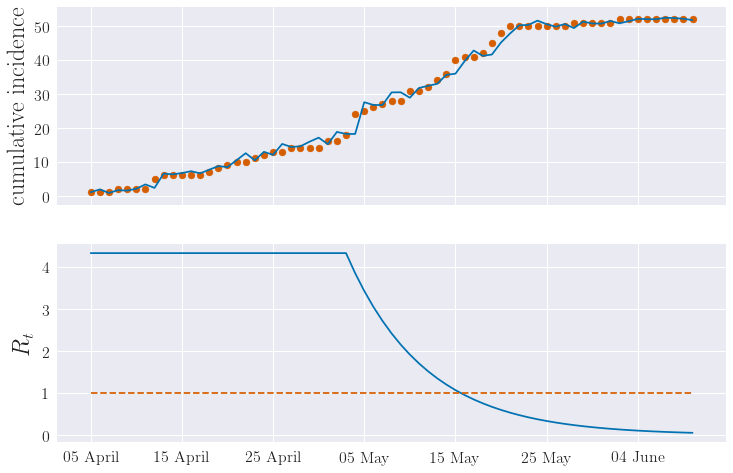

In [10]:
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
axes[0].plot(observations[1],N-zimmer.reconstruct(params_estim)[:,0])
axes[0].scatter(observations[1],N-observations[0],c=colours[2])
axes[1].set_xticks(np.linspace(0,60,7))
axes[1].set_xticklabels(data.Date.dt.strftime('%d %B').values[::10])
axes[0].set_ylabel('cumulative incidence', fontsize=24)
axes[1].plot(observations[1],(params_estim[2]/gamma)*np.exp(-params_estim[3]*np.maximum(observations[1]-tau,0)))
axes[1].plot(observations[1],np.ones(observations[1].shape), c=colours[2], linestyle='--')
axes[1].set_ylabel('$R_t$', fontsize=24)